In [1]:
import pandas as pd
import geopandas as gpd
import random
import fiona
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from geopy.distance import geodesic
from pathlib import Path
import random, os, sys
import numpy as np
import zipfile
import seaborn as sns
from archetypal import IDF
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data_dir = 'C:/Users/mmh/Documents/Data/'
data_dir2 = 'C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/9.Data/'
sys.path.insert(0, 'C:/Users/mmh/Documents/Codes/cross-sectro-transp-energy-model/')
# importlib.reload(sys.modules['src.calculation'])
from src.func_buildings import *

c:\Users\mmh\Anaconda3\envs\py39sim\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# Get locations of buildings
building_loc = gpd.read_file(data_dir+'Buildings/GA/GA_buildings.shp')
building_loc['BuildingClass'] = 'Commercial'
building_loc.loc[building_loc.BuildingTy.isin(['MidriseApartment','HighriseApartment','IECC']),'BuildingClass'] = 'Residential'
building_loc.loc[building_loc.BuildingTy.isin(['SmallOffice','MediumOffice','LargeOffice',
                                              'PrimarySchool','SecondarySchool']),'BuildingClass'] = 'Industrial'
building_cap = pd.read_feather(data_dir+'Buildings/GA/building_cap_100BG.feather')
building_cap = pd.merge(building_cap,building_loc[['ID','BuildingClass']],how='left',on='ID')

In [8]:
print(len(set(building_cap.ID)))

17851


# Schedules of a building 

Two places to change: 1) schedule 2) where schedule is used >>>>>>>>>>>>>>>>>>> effect???
- Schedule: 'Schedule:Day:Interval' - 
- Occupancy: 'People' - 'Number of People Schedule Name' - 'Occ'
- Lighting: 'Lights' - 'Schedule Name' - 'Light'
- Equipment use: 'ElectricEquipment' - 'Schedule Name' - 'Equip'
- Cooling/heating setpoint: 'ThermostatSetpoint:DualSetpoint' - 'Heating Setpoint Temperature Schedule Name' - 'HtgSetp', 'ThermostatSetpoint:DualSetpoint' - 'Cooling Setpoint Temperature Schedule Name' - 'ClgSetp'

### Schedule

In [6]:
type_subset = ['Schedule:Day:Interval']
loc = data_dir+'Buildings/IDF_Fulton/ModelsOrig/'
bname = building_cap.ID.astype(str).values
filenames = bname + '/'+bname+'.idf'
building_set = process_idf(loc,filenames,type_subset=type_subset,name_subset=[],skip=False)
print(len(np.unique(building_set.ID)))

finish processing building 5009016211525/5009016211525.idf
finish processing building 5009016211528/5009016211528.idf
size: 0.0001GB
2


In [7]:
building_set.head()

,type,value,name,name2,ID
602,Schedule:Day:Interval,Medium Office HtgSetp SmrDsn|Sun Day,Name,NaN,5009016211525/5009016211525
603,Schedule:Day:Interval,Temperature,Schedule Type Limits Name,NaN,5009016211525/5009016211525
604,Schedule:Day:Interval,No,Interpolate to Timestep,NaN,5009016211525/5009016211525
605,Schedule:Day:Interval,24:00,Time 1 {hh:mm},NaN,5009016211525/5009016211525
606,Schedule:Day:Interval,15.6,Value Until Time 1,NaN,5009016211525/5009016211525


### where schedule is used
!!! Currently they do not use hourly-variant occupancy schedule (...Default)

In [125]:
# occupancy
occ = building_set[(building_set.type=='Schedule:Day:Interval') & (building_set.name2.str.contains('occ',na=False, case=False))]
occ.head()

,type,value,name,name2,ID,TRACTCE,BLKGRPCE
359,Schedule:Day:Interval,MidriseApartment Apartment Occ Default,Name,MidriseApartment Apartment Occ Default,8019004624875,000400,2
360,Schedule:Day:Interval,Fractional,Schedule Type Limits Name,MidriseApartment Apartment Occ Default,8019004624875,000400,2
361,Schedule:Day:Interval,No,Interpolate to Timestep,MidriseApartment Apartment Occ Default,8019004624875,000400,2
362,Schedule:Day:Interval,07:00,Time 1 {hh:mm},MidriseApartment Apartment Occ Default,8019004624875,000400,2
363,Schedule:Day:Interval,1,Value Until Time 1,MidriseApartment Apartment Occ Default,8019004624875,000400,2


In [117]:
### occupancy
# occ_col= list(set(building_set[(building_set.name2.str.contains('occ',na=False, case=False))].name2))
# building_set[(building_set.value.isin(occ_col)) & (building_set.type!='Schedule:Day:Interval')] # empty dataframe
occ = building_set[(building_set.type=='People') & (building_set.name=='Number of People Schedule Name')]
print(occ.value.value_counts())
occ.head(2)

  MidriseApartment Apartment Occ             805
  Small Office Bldg Occ                       21
  Retail Bldg Occ                             19
  StripMall Bldg Occ                           4
  FullServiceRestaurant Bldg Occ               3
  Outpatient Bldg Occ                          2
  QuickServiceRestaurant Bldg Occ              2
  RetailStripmall Type3_OCC_SCH                1
  ApartmentMidRise OCC_APT_SCH                 1
Name: value, dtype: int64


,type,value,name,name2,ID,TRACTCE,BLKGRPCE
450,People,MidriseApartment Apartment Occ,Number of People Schedule Name,Space Type 1 People,8019004624875,000400,2
967,People,MidriseApartment Apartment Occ,Number of People Schedule Name,Space Type 1 People,8019004624951,000500,2


In [120]:
### heating setpoint
occ = building_set[(building_set.type=='ThermostatSetpoint:DualSetpoint') & (building_set.name=='Heating Setpoint Temperature Schedule Name')]
print(occ.value.value_counts())
occ.head(2)

  MidriseApartment Apartment HtgSetp               814
  Retail HtgSetp                                    25
  Small Office HtgSetp                              21
  Warehouse HtgSetp BulkStorage                     16
  SecondarySchool HtgSetp                           15
  PrimarySchool HtgSetp                             10
  Outpatient HtgSetp                                 4
  StripMall HtgSetp                                  4
  LargeHotel GuestRoom HtgSetp                       4
  OutPatientHealthCare HTGSETP_SCH_YES_OPTIMUM       3
  FullServiceRestaurant HtgSetp                      3
  QuickServiceRestaurant HtgSetp                     2
  RetailStripmall Type3_HTGSETP_SCH_NO_OPTIMUM       1
  ApartmentMidRise HTGSETP_APT_SCH                   1
Name: value, dtype: int64


,type,value,name,name2,ID,TRACTCE,BLKGRPCE
1,ThermostatSetpoint:DualSetpoint,MidriseApartment Apartment HtgSetp,Heating Setpoint Temperature Schedule Name,Space Type 1 Thermostat 1,8019004624875,000400,2
518,ThermostatSetpoint:DualSetpoint,MidriseApartment Apartment HtgSetp,Heating Setpoint Temperature Schedule Name,Space Type 1 Thermostat 1,8019004624951,000500,2


In [121]:
### coolinging setpoint
occ = building_set[(building_set.type=='ThermostatSetpoint:DualSetpoint') & (building_set.name=='Cooling Setpoint Temperature Schedule Name')]
print(occ.value.value_counts())
occ.head(2)

  MidriseApartment Apartment ClgSetp              814
  Retail ClgSetp                                   25
  Small Office ClgSetp                             21
  Warehouse ClgSetp BulkStorage                    16
  SecondarySchool ClgSetp                          15
  PrimarySchool ClgSetp                            10
  Outpatient ClgSetp                                4
  StripMall ClgSetp                                 4
  LargeHotel GuestRoom ClgSetp                      4
  OutPatientHealthCare CLGSETP_SCH_NO_SETBACK       3
  FullServiceRestaurant ClgSetp                     3
  QuickServiceRestaurant ClgSetp                    2
  RetailStripmall Type3_CLGSETP_SCH_NO_SETBACK      1
  ApartmentMidRise CLGSETP_APT_SCH                  1
Name: value, dtype: int64


,type,value,name,name2,ID,TRACTCE,BLKGRPCE
2,ThermostatSetpoint:DualSetpoint,MidriseApartment Apartment ClgSetp,Cooling Setpoint Temperature Schedule Name,Space Type 1 Thermostat 1,8019004624875,000400,2
519,ThermostatSetpoint:DualSetpoint,MidriseApartment Apartment ClgSetp,Cooling Setpoint Temperature Schedule Name,Space Type 1 Thermostat 1,8019004624951,000500,2


In [118]:
### lights
occ = building_set[(building_set.type=='Lights') & (building_set.name=='Schedule Name')]
print(occ.value.value_counts())
occ.head(2)

  MidriseApartment Apartment Light           810
  Office Bldg Light                           21
  Retail Bldg Light                           20
  Warehouse Bldg Light                        16
  StripMall Bldg Light                         4
  FullServiceRestaurant Bldg Light             3
  Outpatient Bldg Light                        2
  QuickServiceRestaurant Bldg Light            2
  ApartmentMidRise LTG_APT_SCH                 2
  PrimarySchool Bldg Light                     1
  RetailStripmall Type3_LIGHT_SCH              1
Name: value, dtype: int64


,type,value,name,name2,ID,TRACTCE,BLKGRPCE
438,Lights,MidriseApartment Apartment Light,Schedule Name,Space Type 1 Lights,8019004624875,000400,2
955,Lights,MidriseApartment Apartment Light,Schedule Name,Space Type 1 Lights,8019004624951,000500,2


In [119]:
### equipment
occ = building_set[(building_set.type=='ElectricEquipment') & (building_set.name=='Schedule Name')]
print(occ.value.value_counts())
occ.head(2)

  ApartmentMidRise EQP_APT_SCH               797
  Small Office Bldg Equip                     20
  Retail Bldg Equip                           17
  Warehouse Bldg Equip                        16
  StripMall Bldg Equip                         4
  FullServiceRestaurant Bldg Equip             3
  Outpatient Bldg Equip                        2
  QuickServiceRestaurant Bldg Equip            2
  RetailStripmall Type3_EQUIP_SCH              1
Name: value, dtype: int64


,type,value,name,name2,ID,TRACTCE,BLKGRPCE
469,ElectricEquipment,ApartmentMidRise EQP_APT_SCH,Schedule Name,Space Type 1 Elec Equip,8019004624875,000400,2
986,ElectricEquipment,ApartmentMidRise EQP_APT_SCH,Schedule Name,Space Type 1 Elec Equip,8019004624951,000500,2


# Default occupancy of a building

In [16]:
schedule_set = ['ApartmentMidRise EQP_APT_SCH Default','MidriseApartment Apartment Light Default','Occ Default']
df = building_set.loc[(building_set.type=='Schedule:Day:Interval') & 
                      (building_set.name2.str.contains('ApartmentMidRise EQP_APT_SCH Default',na=False))]
df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
df['cat'] = df.name.str.split().str.get(0)
df.head()

,type,value,name,name2,ID,cat
1163,Schedule:Day:Interval,01:00,Time 1 {hh:mm},ApartmentMidRise EQP_APT_SCH Default,8019004624875,Time
1164,Schedule:Day:Interval,0.45,Value Until Time 1,ApartmentMidRise EQP_APT_SCH Default,8019004624875,Value
1165,Schedule:Day:Interval,02:00,Time 2 {hh:mm},ApartmentMidRise EQP_APT_SCH Default,8019004624875,Time
1166,Schedule:Day:Interval,0.41,Value Until Time 2,ApartmentMidRise EQP_APT_SCH Default,8019004624875,Value
1167,Schedule:Day:Interval,03:00,Time 3 {hh:mm},ApartmentMidRise EQP_APT_SCH Default,8019004624875,Time


In [17]:
n = len(np.unique(df.ID))
j = 0
schedule = pd.DataFrame()
for i in np.unique(df.ID):
    group = df[df.ID == i]
    x = group.groupby('cat')['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
    x['ID'] = i
    schedule = schedule.append(x)
schedule['Time'] = pd.to_numeric(schedule['Time'].str.split(":").str.get(0))
hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
hours['ID'] = np.repeat(np.unique(df.ID),24)
schedule = pd.merge(hours,schedule,how='left',on=['ID','Time'])
schedule['Value'] = schedule['Value'].fillna(method='bfill')
schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
schedule['Value'] = pd.to_numeric(schedule['Value'])
schedule.head()

,Time,ID,Value,BuildingClass
0,1,8019004624875,0.45,Residential
1,2,8019004624875,0.41,Residential
2,3,8019004624875,0.39,Residential
3,4,8019004624875,0.38,Residential
4,5,8019004624875,0.38,Residential


<Axes: xlabel='Time', ylabel='Value'>

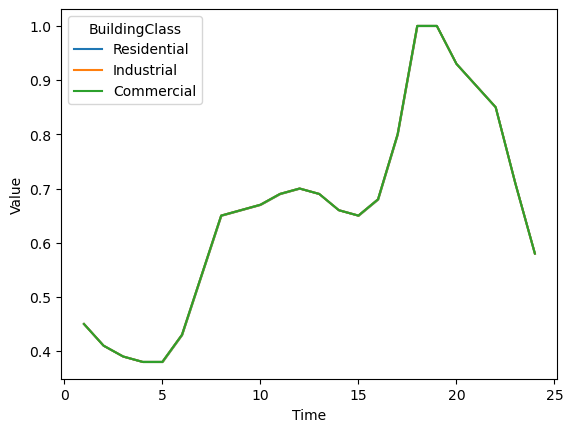

In [18]:
sns.lineplot(data = schedule, y='Value',x='Time',hue = 'BuildingClass')

<Axes: xlabel='Time', ylabel='Value'>

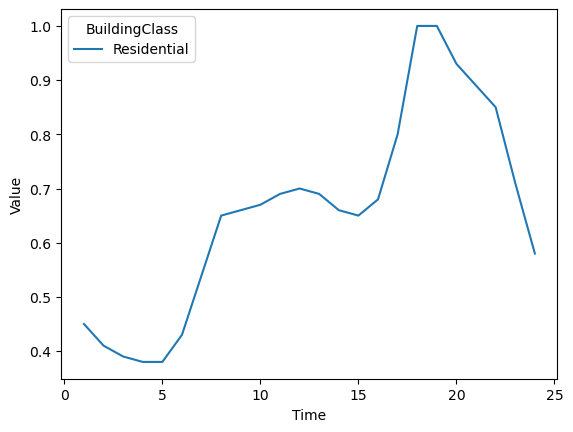

In [19]:
sns.lineplot(data = schedule[schedule.ID==8019004624875], y='Value',x='Time',hue = 'BuildingClass')

## Issue 1: inconsistent building type

In [73]:
type_inconsistent = building_loc.pivot_table(index='BuildingType', columns='BuildingType_idf', values='ID',
                        aggfunc='count', fill_value=0)
type_inconsistent

BuildingType_idf,FullServiceRestaurant,LargeHotel,MidriseApartment,Outpatient,PrimarySchool,QuickServiceRestaurant,RetailStandalone,RetailStripmall,SecondarySchool,SmallOffice,Warehouse
BuildingType,,,,,,,,,,,
FullServiceRestaurant,0,0,4,0,0,0,0,0,0,1,0
HighriseApartment,0,1,10,0,2,0,4,0,2,0,6
Hospital,0,0,0,0,0,0,0,0,1,0,3
IECC,3,0,762,0,0,1,0,0,0,17,0
LargeHotel,0,0,0,0,0,0,0,0,2,0,3
LargeOffice,0,0,8,1,2,0,5,0,2,0,4
MediumOffice,0,0,12,1,0,0,2,0,0,1,0
MidriseApartment,0,0,3,0,0,0,1,1,0,0,0
Outpatient,0,0,0,1,0,0,1,0,0,0,0


## Issue 2: Missing IDFs

In [69]:
print(len(set(building_loc.ID)))
print(len(set(building_set.ID)))

901
900


In [71]:
building_loc[building_loc.ID == 8019004678009]# hospital

,Unnamed: 0,ID,Centroid,Footprint2D,State_Abbr,Area,Area2D,Height,NumFloors,WWR_surfaces,CZ,BuildingType,Standard,latitude,longitude,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,BuildingType_idf
